In [2]:
pip install numpy scikit-image tensorflow matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imported Libraries

import os
import random
import shutil
import glob

import numpy
from skimage.io import imread,imshow
from skimage.transform import resize
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras 

from keras.layers import Input,Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merging import concatenate
from keras import backend
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [2]:
# Extracting the Data(Images) to be used
shutil.unpack_archive('Unet_data.zip')
data_size=len(glob.glob('Unet_data/images/**'))

# Function to delete old data and Create the Folders again.
def createdirs():
    try:
        os.makedirs('Unet_data/train/images')  
        os.makedirs('Unet_data/test/images')
        os.makedirs('Unet_data/valid/images')
        os.makedirs('Unet_data/train/mask')
        os.makedirs('Unet_data/test/mask')
        os.makedirs('Unet_data/valid/mask')
    except:
        shutil.rmtree('Unet_data/train') # Remove the directory and all the files and subdirectories.
        shutil.rmtree('Unet_data/test')
        shutil.rmtree('Unet_data/valid')
        createdirs()
createdirs()

# Separating Data into Train, Test and Validation Sets.
random.seed(10)
for i in random.sample(glob.glob('Unet_data/images/*'), int(0.8*data_size)):
    shutil.move(i, 'Unet_data/train/images')
    shutil.move('Unet_data/masks/'+i.split('\\')[1].split('.')[0]+'_mask.png','Unet_data/train/mask')  
for i in random.sample(glob.glob('Unet_data/images/**'), int(0.1*data_size)):
    shutil.move(i, 'Unet_data/test/images')   
    shutil.move('Unet_data/masks/'+i.split('\\')[1].split('.')[0]+'_mask.png','Unet_data/test/mask')  
for i in random.sample(glob.glob('Unet_data/images/**'), int(0.1*data_size)):
    shutil.move(i, 'Unet_data/valid/images')   
    shutil.move('Unet_data/masks/'+i.split('\\')[1].split('.')[0]+'_mask.png','Unet_data/valid/mask')


In [3]:
# Paths where data is stored.
train_path='Unet_data/train'
test_path='Unet_data/test'
valid_path='Unet_data/valid'

# Dimensions to which image is to be resized.
img_h=256
img_w=256
img_c=1 

In [4]:
# Function to convert images to ndarray so that model can be trained.
def preprocess(path):
    images=next(os.walk(path+"/images"))[2] # List of Names of Images
    print("No. of images = ",len(images))
    print(images)

    x = numpy.zeros((len(images),img_h,img_w,img_c),dtype=numpy.float32) # Array to store images
    y = numpy.zeros((len(images),img_h,img_w,img_c),dtype=numpy.float32)

    for n,i in enumerate(images):
        # Load images
        img=imread(path+'/images/'+str(i),as_gray=True)
        img=resize(img,(img_h,img_w,img_c),mode='constant',preserve_range=True)
        # Load masks
        mask=imread(path+'/mask/'+str(i).split('.')[0]+'_mask.png', as_gray=True) # Getting the mask for the image
        mask=resize(mask,(img_h,img_w,img_c),mode='constant',preserve_range=True)
        # Save images
        x[n]=img/255
        y[n]=mask/255
    return x,y

x_train,y_train=preprocess(train_path) # Training Dataset

No. of images =  400
['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '106.png', '107.png', '109.png', '11.png', '111.png', '112.png', '113.png', '114.png', '117.png', '118.png', '119.png', '12.png', '120.png', '123.png', '125.png', '127.png', '128.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '147.png', '148.png', '149.png', '15.png', '151.png', '153.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', '182.png', '184.png', '186.png', '187.png', '188.png', '189.png', '19.png', '190.png', '191.png', '193.png', '194.png', '195.png', '196.png', '198.png', '2.png', '20.png', '200.png', '201.png', '202.png', '2

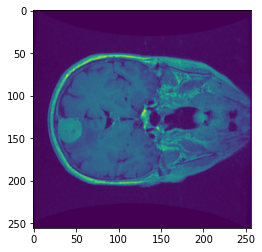

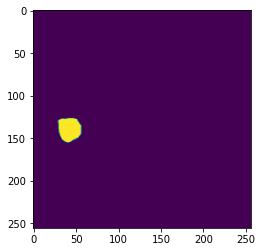

In [5]:
random.seed(10)
image_x = random.randint(0,len(x_train))
plt.imshow(numpy.squeeze(x_train[image_x])) 
plt.show()
plt.imshow(numpy.squeeze(y_train[image_x]))
plt.show()

In [6]:
#Testing Dataset
x_test,y_test=preprocess(test_path)
#Validation Dataset
x_valid,y_valid=preprocess(valid_path)

No. of images =  50
['105.png', '115.png', '121.png', '126.png', '146.png', '150.png', '152.png', '154.png', '157.png', '158.png', '17.png', '181.png', '183.png', '192.png', '197.png', '232.png', '240.png', '241.png', '263.png', '27.png', '279.png', '280.png', '288.png', '302.png', '317.png', '32.png', '330.png', '332.png', '334.png', '335.png', '354.png', '355.png', '389.png', '396.png', '399.png', '403.png', '41.png', '410.png', '415.png', '416.png', '417.png', '420.png', '421.png', '433.png', '437.png', '464.png', '50.png', '87.png', '90.png', '93.png']
No. of images =  50
['0.png', '108.png', '110.png', '116.png', '122.png', '124.png', '129.png', '145.png', '155.png', '156.png', '185.png', '199.png', '204.png', '213.png', '225.png', '243.png', '255.png', '260.png', '272.png', '282.png', '291.png', '312.png', '315.png', '316.png', '333.png', '336.png', '340.png', '341.png', '342.png', '382.png', '391.png', '395.png', '40.png', '413.png', '419.png', '425.png', '43.png', '44.png', '44

In [7]:
# Function to calculate Dice Score
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

<h2>Model 1</h2>

In [8]:
# model 1 Convolutional layers with 512 maximum filters and 4,4 kernal size

input = Input((img_h,img_w,img_c))

# Contracting path

c1 = Conv2D(16,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(input) # Creating a convolutional layer
c1 = Dropout(0.1)(c1)           # Creating a layer to drop random features
c1 = Conv2D(16,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)    # Used to down sample the input 

c2 = Conv2D(32,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c6 = Conv2D(512,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(p5)
c6 = Dropout(0.4)(c6)
c6 = Conv2D(512,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(c5)
p6 = MaxPooling2D(pool_size=(2, 2))(c6)

#Expansive path 
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(p6) # Creating a deconvolutional layer
u7 = concatenate([u7, c5])  # Concatinating the layers
c7 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.4)(c7)
c7 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.3)(c8)
c8 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='valid')(c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = Dropout(0.1)(c10)
c10 = Conv2D(32, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
 
u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = Dropout(0.1)(c11)
c11 = Conv2D(16, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11) # Output layer has sigmoid activation to parse the values between 0 and 1

model = tf.keras.Model(inputs=[input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # add all the layers defined to model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  272         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

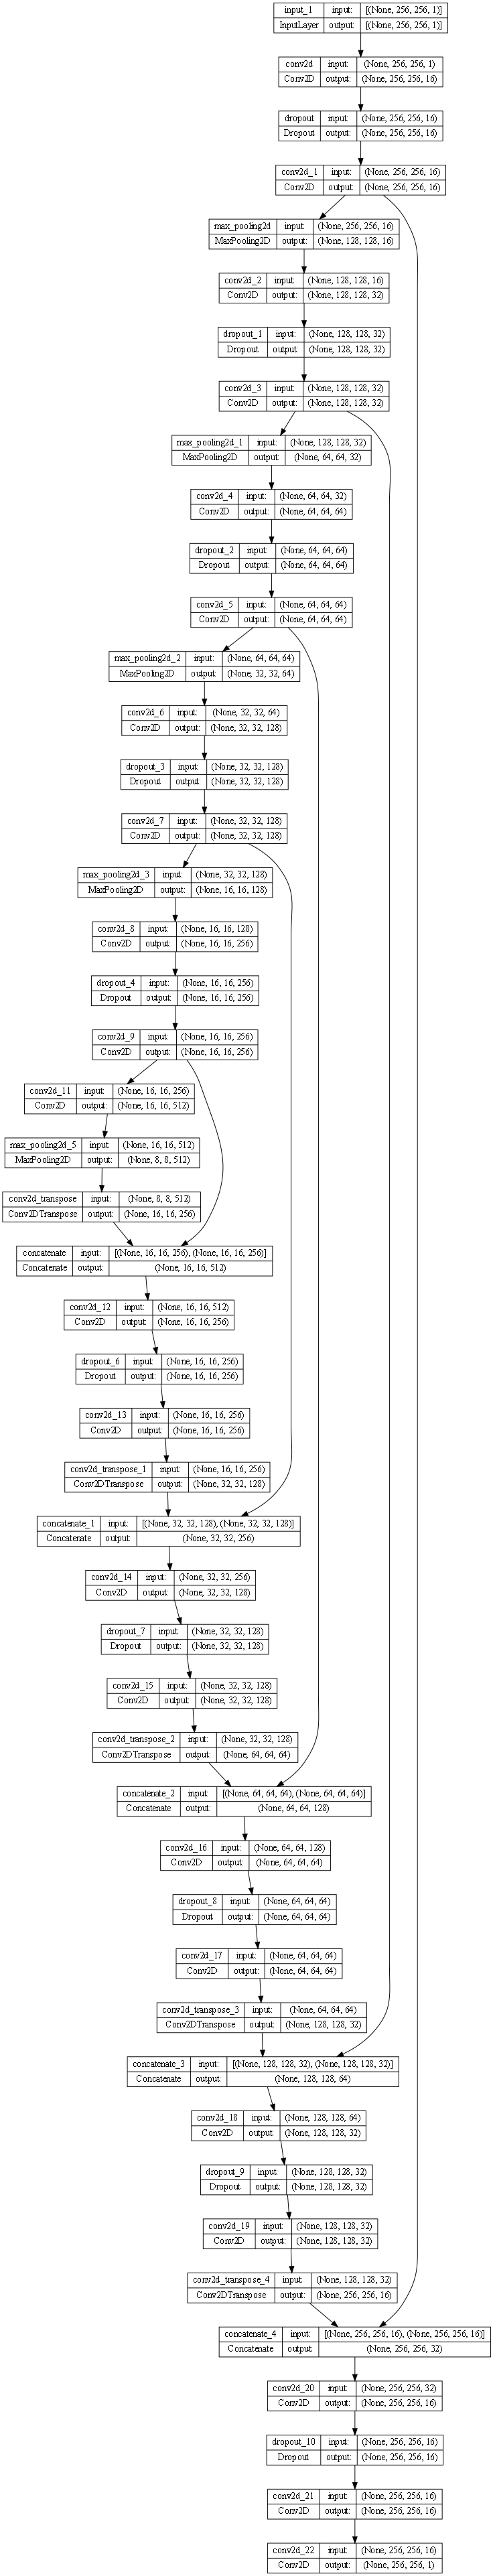

In [9]:
plot_model(model,show_shapes = True,dpi=70) # Respresentaion of the Model

In [10]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5,restore_best_weights=True) # Method to prevent Overfitting of Models.
results = model.fit(x_train, y_train, batch_size=10, epochs=50,validation_data=(x_valid, y_valid),callbacks=[early_stop]) # Training the model
model.save('model1')

Epoch 1/50
40/40 [==============================] - 306s 8s/step - loss: 0.3049 - accuracy: 0.9563 - val_loss: 0.1137 - val_accuracy: 0.9788
Epoch 2/50
40/40 [==============================] - 315s 8s/step - loss: 0.0758 - accuracy: 0.9797 - val_loss: 0.0841 - val_accuracy: 0.9788
Epoch 3/50
40/40 [==============================] - 287s 7s/step - loss: 0.0590 - accuracy: 0.9797 - val_loss: 0.0706 - val_accuracy: 0.9788
Epoch 4/50
40/40 [==============================] - 332s 8s/step - loss: 0.0559 - accuracy: 0.9797 - val_loss: 0.0737 - val_accuracy: 0.9788
Epoch 5/50
40/40 [==============================] - 297s 7s/step - loss: 0.0561 - accuracy: 0.9797 - val_loss: 0.0722 - val_accuracy: 0.9788
Epoch 6/50
40/40 [==============================] - 317s 8s/step - loss: 0.0507 - accuracy: 0.9797 - val_loss: 0.0589 - val_accuracy: 0.9788
Epoch 7/50
40/40 [==============================] - 309s 8s/step - loss: 0.0480 - accuracy: 0.9797 - val_loss: 0.0934 - val_accuracy: 0.9764
Epoch 8/50
40

In [11]:
# Making Predictions based on the trained model
preds_test = model.predict(x_test, verbose=1)
preds_train = model.predict(x_train, verbose=1)

13/13 [==============================] - 29s 2s/step


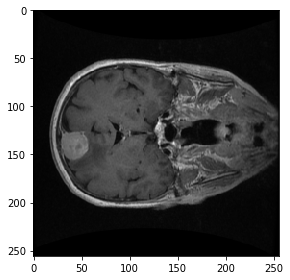

C:\Program Files\Python\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


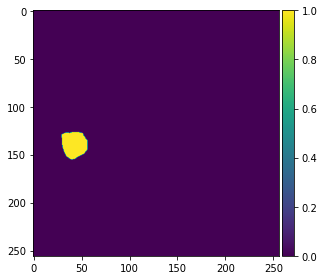

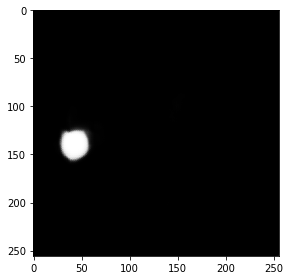

In [12]:
imshow(numpy.squeeze(x_train[image_x]))
plt.show()
imshow(numpy.squeeze(y_train[image_x]),vmin=0,vmax=1)
plt.show()
imshow(numpy.squeeze(preds_train[image_x]))
plt.show()


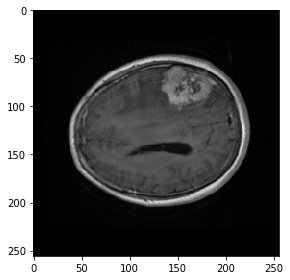

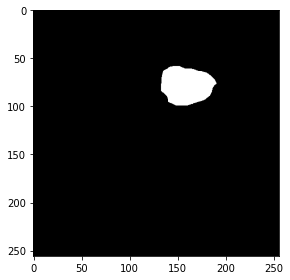

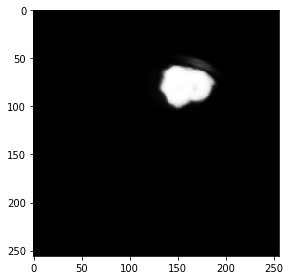

In [13]:
imshow(numpy.squeeze(x_test[0]))
plt.show()
imshow(numpy.squeeze(y_test[0]))
plt.show()
imshow(numpy.squeeze(preds_test[0]))
plt.show()

In [14]:
print(dice_coef(y_test,preds_test)) #Dice Score of the Current Model

tf.Tensor(0.8443027, shape=(), dtype=float32)


<h2>Model 2</h2>

In [15]:
# model 2 Convolutional layers with 512 maximum filters and 4,4 kernal size and Dense layers after dropout layers.

input = Input((img_h,img_w,img_c))

# Contracting path

c1 = Conv2D(16,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(input)
c1 = Dropout(0.1)(c1)
c1 = Dense(16,activation="relu",kernel_initializer="he_normal")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(p1)
c2 = Dropout(0.1)(c2)
c2 = Dense(32,activation="relu",kernel_initializer="he_normal")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Dense(64, activation='relu', kernel_initializer='he_normal')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Dense(128, activation='relu', kernel_initializer='he_normal')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Dense(256, activation='relu', kernel_initializer='he_normal')(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c6 = Conv2D(512,(4,4),activation="relu",kernel_initializer="he_normal",padding = "same")(p5)
c6 = Dropout(0.4)(c6)
c6 = Dense(512,activation="relu",kernel_initializer="he_normal")(c5)
p6 = MaxPooling2D(pool_size=(2, 2))(c6)

#Expansive path 
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(p6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.4)(c7)
c7 = Dense(256, activation='relu', kernel_initializer='he_normal')(c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.3)(c8)
c8 = Dense(128, activation='relu', kernel_initializer='he_normal')(c8)
 
u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)
c9 = Dense(64, activation='relu', kernel_initializer='he_normal')(c9)
 
u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='valid')(c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = Dropout(0.1)(c10)
c10 = Dense(32, activation='relu', kernel_initializer='he_normal')(c10)
 
u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (4,4), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = Dropout(0.1)(c11)
c11 = Dense(16, activation='relu', kernel_initializer='he_normal')(c11)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
 
model = tf.keras.Model(inputs=[input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  272         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 256, 256, 16  0           ['conv2d_23[0][0]']              
                                )                                                           

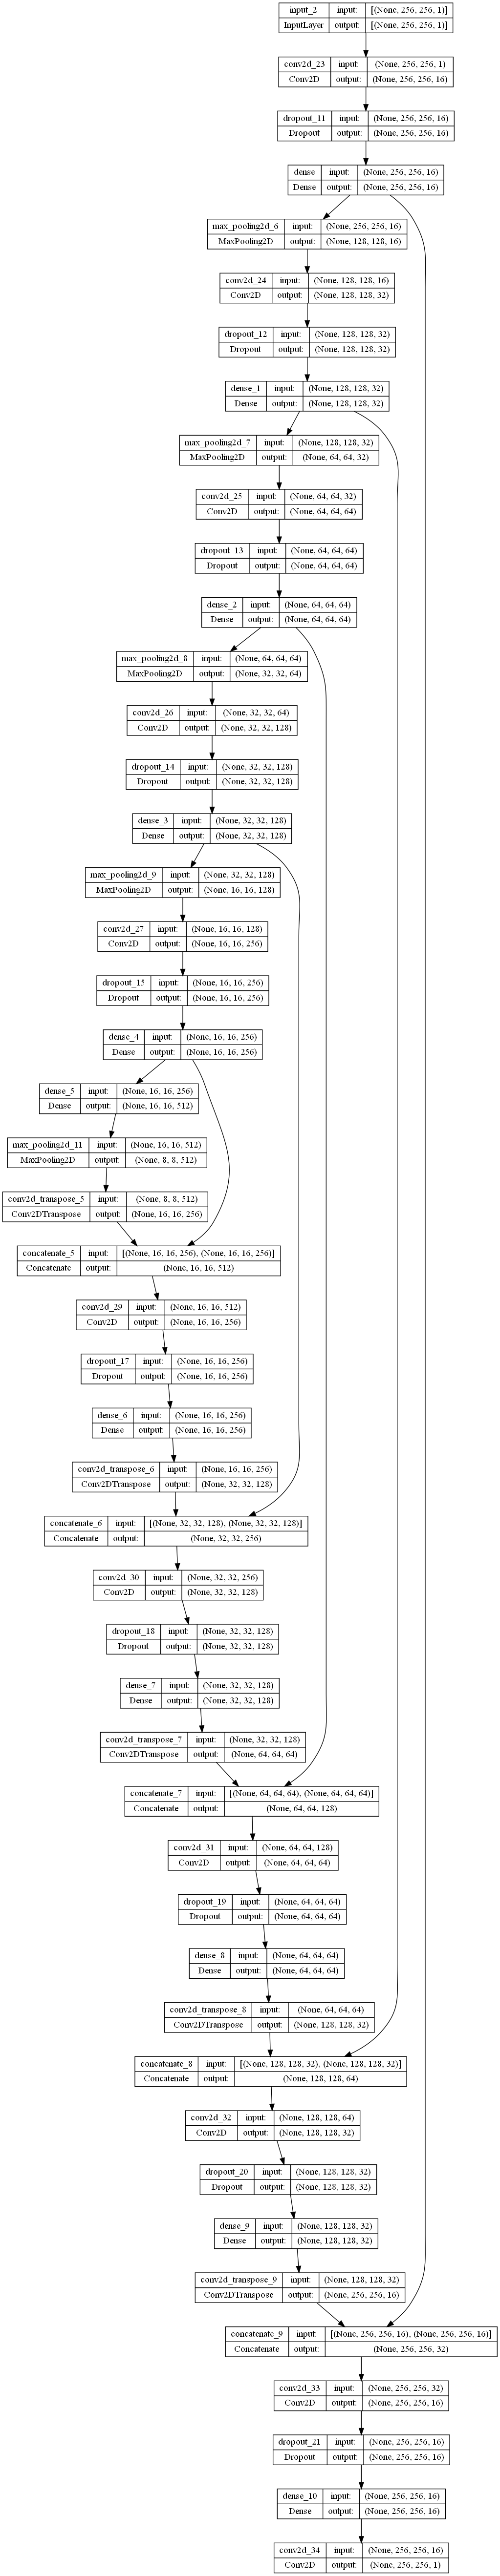

In [16]:
plot_model(model,show_shapes = True)

In [17]:
results = model.fit(x_train, y_train, batch_size=10, epochs=50,validation_data=(x_valid, y_valid),callbacks=[early_stop])
model.save('model2')

Epoch 1/50
40/40 [==============================] - 218s 5s/step - loss: 0.2307 - accuracy: 0.9370 - val_loss: 0.1402 - val_accuracy: 0.9788
Epoch 2/50
40/40 [==============================] - 286s 7s/step - loss: 0.0750 - accuracy: 0.9796 - val_loss: 0.1159 - val_accuracy: 0.9788
Epoch 3/50
40/40 [==============================] - 265s 7s/step - loss: 0.0587 - accuracy: 0.9796 - val_loss: 0.0975 - val_accuracy: 0.9788
Epoch 4/50
40/40 [==============================] - 266s 7s/step - loss: 0.0474 - accuracy: 0.9797 - val_loss: 0.0877 - val_accuracy: 0.9788
Epoch 5/50
40/40 [==============================] - 197s 5s/step - loss: 0.0401 - accuracy: 0.9797 - val_loss: 0.0607 - val_accuracy: 0.9788
Epoch 6/50
40/40 [==============================] - 170s 4s/step - loss: 0.0403 - accuracy: 0.9797 - val_loss: 0.0848 - val_accuracy: 0.9788
Epoch 7/50
40/40 [==============================] - 248s 6s/step - loss: 0.0324 - accuracy: 0.9809 - val_loss: 0.0856 - val_accuracy: 0.9741
Epoch 8/50
40

In [18]:
preds_test = model.predict(x_test, verbose=1)
preds_train = model.predict(x_train, verbose=1)



13/13 [==============================] - 22s 2s/step


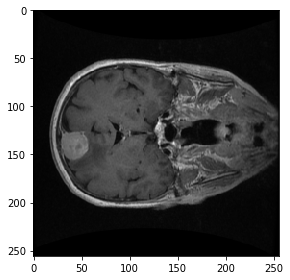

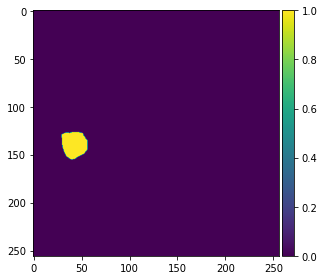

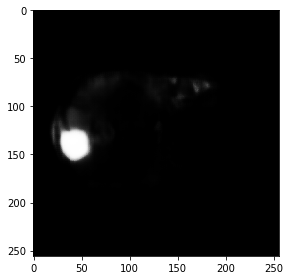

In [19]:
imshow(numpy.squeeze(x_train[image_x]))
plt.show()
imshow(numpy.squeeze(y_train[image_x]),vmin=0,vmax=1)
plt.show()
imshow(numpy.squeeze(preds_train[image_x]))
plt.show()


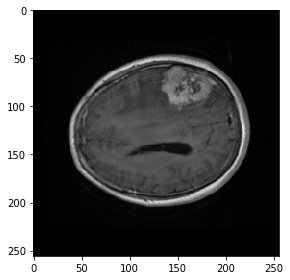

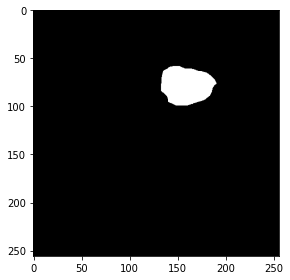

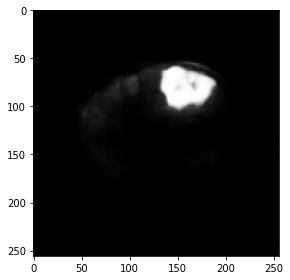

In [20]:
imshow(numpy.squeeze(x_test[0]))
plt.show()
imshow(numpy.squeeze(y_test[0]))
plt.show()
imshow(numpy.squeeze(preds_test[0]))
plt.show()

In [21]:
print(dice_coef(y_test,preds_test))

tf.Tensor(0.65019876, shape=(), dtype=float32)


<h2>Model 3</h2>

In [22]:
# model 3 Convolutional layers with 512 maximum filters and 3,3 kernal size and dice score as metric

input = Input((img_h,img_w,img_c))

# Contracting path
initial=tf.keras.initializers.HeNormal(seed=None)

c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer=initial, padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer=initial, padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer=initial, padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c6 = Conv2D(512,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(p5)
c6 = Dropout(0.4)(c6)
c6 = Conv2D(512,(3,3),activation="relu",kernel_initializer=initial,padding = "same")(c5)
p6 = MaxPooling2D(pool_size=(2, 2))(c6)

#Expansive path 
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(p6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer=initial, padding='same')(u7)
c7 = Dropout(0.4)(c7)
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer=initial, padding='same')(u8)
c8 = Dropout(0.3)(c8)
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c8)
 
u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer=initial, padding='same')(u9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c9)
 
u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='valid')(c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3,3), activation='relu', kernel_initializer=initial, padding='same')(u10)
c10 = Dropout(0.1)(c10)
c10 = Conv2D(32, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c10)
 
u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3,3), activation='relu', kernel_initializer=initial, padding='same')(u11)
c11 = Dropout(0.1)(c11)
c11 = Conv2D(16, (3,3), activation='relu', kernel_initializer=initial, padding='same')(c11)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
 
model = tf.keras.Model(inputs=[input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
results = model.fit(x_train, y_train, batch_size=10, epochs=50,validation_data=(x_valid, y_valid),callbacks=[early_stop]) # 

Epoch 1/50
40/40 [==============================] - 252s 6s/step - loss: 0.2556 - accuracy: 0.9730 - val_loss: 0.0950 - val_accuracy: 0.9788
Epoch 2/50
40/40 [==============================] - 241s 6s/step - loss: 0.0746 - accuracy: 0.9797 - val_loss: 0.0633 - val_accuracy: 0.9788
Epoch 3/50
40/40 [==============================] - 227s 6s/step - loss: 0.0570 - accuracy: 0.9797 - val_loss: 0.0556 - val_accuracy: 0.9788
Epoch 4/50
40/40 [==============================] - 149s 4s/step - loss: 0.0510 - accuracy: 0.9797 - val_loss: 0.0456 - val_accuracy: 0.9788
Epoch 5/50
40/40 [==============================] - 147s 4s/step - loss: 0.0443 - accuracy: 0.9797 - val_loss: 0.0395 - val_accuracy: 0.9788
Epoch 6/50
40/40 [==============================] - 147s 4s/step - loss: 0.0389 - accuracy: 0.9797 - val_loss: 0.0402 - val_accuracy: 0.9788
Epoch 7/50
40/40 [==============================] - 148s 4s/step - loss: 0.0358 - accuracy: 0.9797 - val_loss: 0.0385 - val_accuracy: 0.9788
Epoch 8/50
40

In [24]:
model.compile(optimizer='adam', loss=dice_coef_loss,metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_22 (Dropout)           (None, 256, 256, 16  0           ['conv2d_46[0][0]']              
                                )                                                           

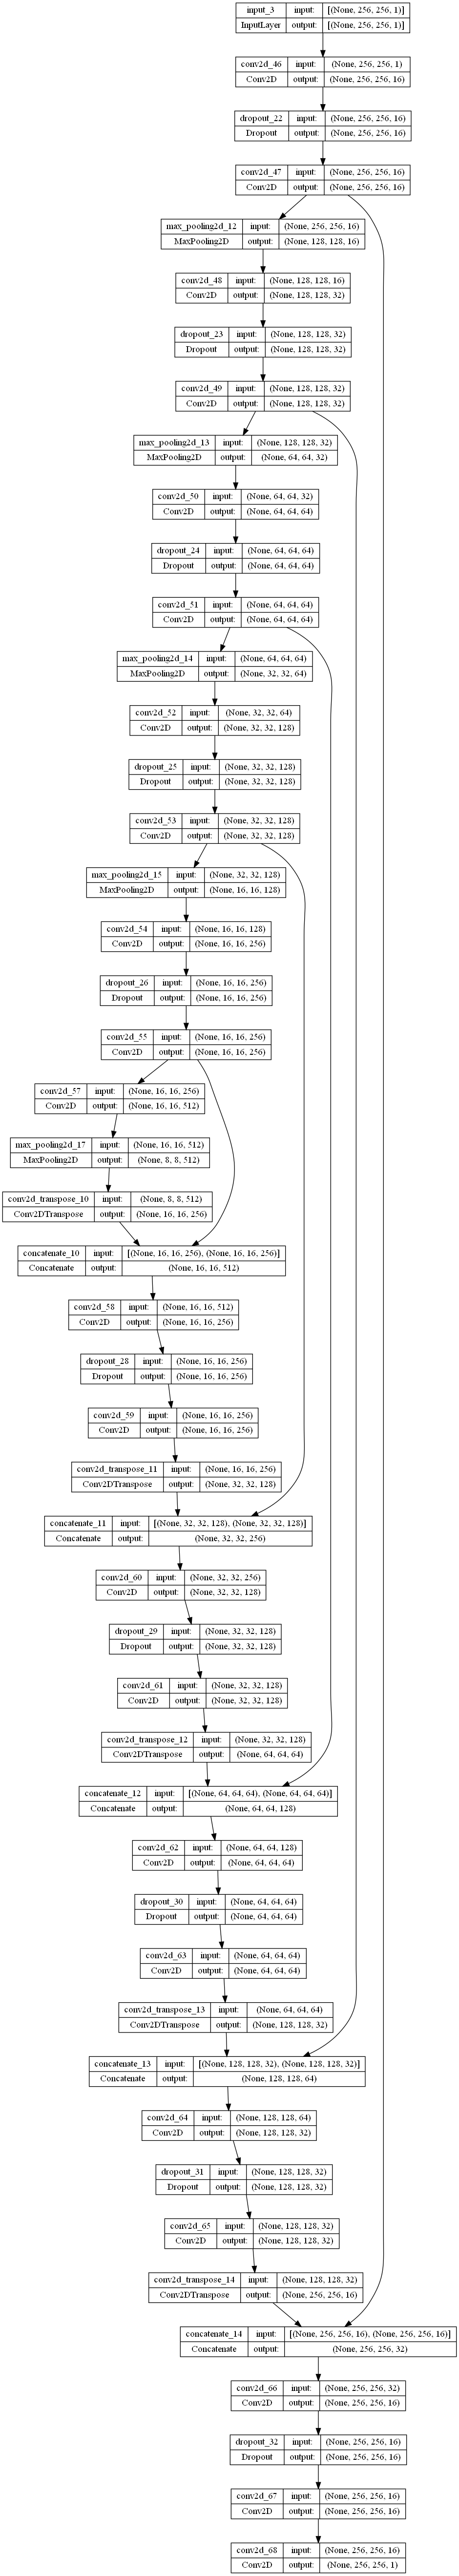

In [25]:
plot_model(model,show_shapes = True)

In [26]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)
results = model.fit(x_train, y_train, batch_size=10, epochs=50,validation_data=(x_valid, y_valid),callbacks=[early_stop])
model.save('model3')

Epoch 1/50
40/40 [==============================] - 205s 5s/step - loss: -0.8868 - dice_coef: 0.8868 - val_loss: -0.8558 - val_dice_coef: 0.8558
Epoch 2/50
40/40 [==============================] - 148s 4s/step - loss: -0.9183 - dice_coef: 0.9183 - val_loss: -0.8571 - val_dice_coef: 0.8571
Epoch 3/50
40/40 [==============================] - 146s 4s/step - loss: -0.9139 - dice_coef: 0.9139 - val_loss: -0.8762 - val_dice_coef: 0.8762
Epoch 4/50
40/40 [==============================] - 225s 6s/step - loss: -0.9060 - dice_coef: 0.9060 - val_loss: -0.8402 - val_dice_coef: 0.8402
Epoch 5/50
40/40 [==============================] - 239s 6s/step - loss: -0.9170 - dice_coef: 0.9170 - val_loss: -0.8991 - val_dice_coef: 0.8991
Epoch 6/50
40/40 [==============================] - 231s 6s/step - loss: -0.9058 - dice_coef: 0.9058 - val_loss: -0.8064 - val_dice_coef: 0.8064
Epoch 7/50
40/40 [==============================] - 258s 6s/step - loss: -0.8738 - dice_coef: 0.8738 - val_loss: -0.8707 - val_dic

In [27]:
preds_test = model.predict(x_test, verbose=1)
preds_train = model.predict(x_train, verbose=1)



13/13 [==============================] - 35s 3s/step


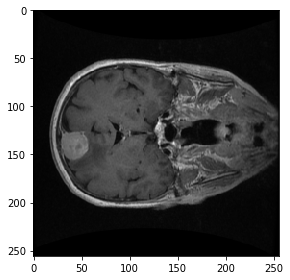

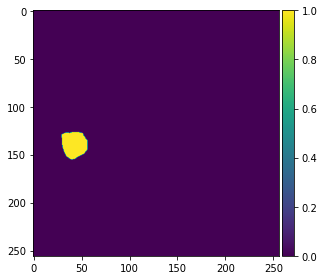

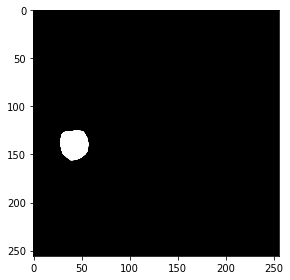

In [28]:
imshow(numpy.squeeze(x_train[image_x]))
plt.show()
imshow(numpy.squeeze(y_train[image_x]),vmin=0,vmax=1)
plt.show()
imshow(numpy.squeeze(preds_train[image_x]))
plt.show()


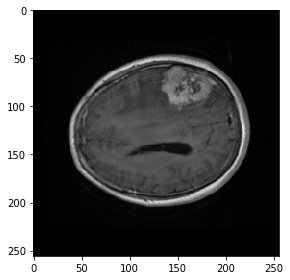

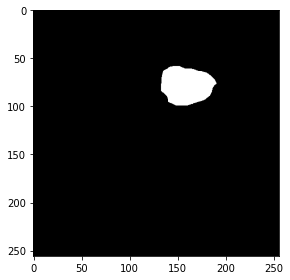

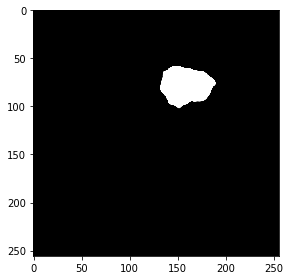

In [29]:
imshow(numpy.squeeze(x_test[0]))
plt.show()
imshow(numpy.squeeze(y_test[0]))
plt.show()
imshow(numpy.squeeze(preds_test[0]))
plt.show()

In [30]:
print(dice_coef(y_test,preds_test))

tf.Tensor(0.8936652, shape=(), dtype=float32)
